This program will require that you install the following modules in advance: 

Run this block of code now:

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

This one might be tough. I haven't had to make graphs in Python for quite a while.

The first things I had to do were to download all three datasets, skim through the paper and figure out which dataset corresponds to which column in fig.1 (iaps.csv = column 1, moth.csv = column 2, decisions.csv = column 3)

Next, let's just read in the three csv files so we have DataFrames for ease of access:

In [5]:
file_path_decisions = 'decisions.csv'
file_path_iaps = 'iaps.csv'
file_path_moth = 'moth.csv'

df_decisions = pd.read_csv(file_path_decisions)
df_iaps = pd.read_csv(file_path_iaps)
df_moth = pd.read_csv(file_path_moth)

Let's get the important data from each of the excel sheets. 

In [6]:
datasets = {
    'Social Decisions': (df_decisions, 'Subject', 'Trial', 'Prop_Returned'),
    'Affective Images': (df_iaps, 'Subject', 'Item', 'Rating'),
    'Emotional Videos': (df_moth, 'workerId', 'timeStamp', 'ratingScore')
}

Test to make sure I did everything correctly. 

In [7]:
for context, (data, participant_col, item_col, rating_col) in datasets.items():
    print(context, data, participant_col, item_col, rating_col)

Social Decisions       Subject  Investment_Amount  Multiplier  Prop_Returned  Returned  \
0         123                  6           4       0.291667         7   
1         123                  7           4       0.500000        14   
2         123                  6           6       0.388889        14   
3         123                  3           6       0.611111        11   
4         123                  3           6       0.277778         5   
...       ...                ...         ...            ...       ...   
4555      192                  4           6       0.416667        10   
4556      192                  9           6       0.500000        27   
4557      192                  5           6       0.400000        12   
4558      192                  6           4       0.416667        10   
4559      192                  1           2       0.000000         0   

      Second_Order_Expectation  Fairness  Soc1  Soc2   Trial  
0                           12      10.0  1

Everything looks like it's being read in correctly. The following code will build a dataframe titled pairwise_results with all of the results of our three pairwise analyses. This was definitely the toughest nut to crack between these two programming questions but I got it functional in the end. 

In [12]:
pairwise_results = []

for context, (data, participant_col, item_col, rating_col) in datasets.items():
    if context == 'Affective Images':
        dimensions = data['Appraisal_Dimension'].unique()           #Finds all unique Appraisal Dimension data from IAPS + makes a list of them
        #display(dimensions)
        
        for dim in dimensions:       #for each emotion (disgust, sad, etc)
            dim_data = data[data['Appraisal_Dimension'] == dim] #get all the data for that specific emotion only
            #display(dim_data)
            
            aggregated = dim_data.groupby([participant_col, item_col])[rating_col].mean().reset_index()  #groups data by the three columns we actually care about
            #display(aggregated)
            
            matrix = aggregated.pivot(index=item_col, columns=participant_col, values=rating_col) #pivots table so user IDs are column headers
            matrix = matrix.dropna(axis=0, how='any').dropna(axis=1, how='any')  #drops all columns and rows with NaN values
            #display(matrix)
            
            pairwise_corr = matrix.corr(method='pearson').stack() #turns the data into a matrix
            pairwise_results.append(pd.DataFrame({'Correlation': pairwise_corr, 'Context': context, 'Dimension': dim})) #adds our data into the pairwise_results dataframe, which at this point is empty until this line is run

            # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
             #   display(aggregated)
                


            #the next two else statements are essentially just copy pasted from the first one, just mildly edited to fit the different datasets
    elif context == 'Emotional Videos':
        movies = data['movie'].unique()
        for movie in movies:
            movie_data = data[data['movie'] == movie]
            aggregated = movie_data.groupby([participant_col, item_col])[rating_col].mean().reset_index()
            matrix = aggregated.pivot(index=item_col, columns=participant_col, values=rating_col)
            matrix = matrix.dropna(axis=0, how='any').dropna(axis=1, how='any')
            pairwise_corr = matrix.corr(method='pearson').stack()
            pairwise_results.append(pd.DataFrame({'Correlation': pairwise_corr, 'Context': context, 'Movie': movie}))

                
    else:
        aggregated = data.groupby([participant_col, item_col])[rating_col].mean().reset_index()
        matrix = aggregated.pivot(index=item_col, columns=participant_col, values=rating_col)
        matrix = matrix.dropna(axis=0, how='any').dropna(axis=1, how='any')
        pairwise_corr = matrix.corr(method='pearson').stack()
        pairwise_results.append(pd.DataFrame({'Correlation': pairwise_corr, 'Context': context}))

pairwise_results = pd.concat(pairwise_results, ignore_index=True)

This next bit generates a graph for the data below. 

/var/folders/fw/5_zdpkmd5mgft85f2j4q8ry00000gn/T/ipykernel_16246/3753861471.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Context', y='Correlation', data=pairwise_results,


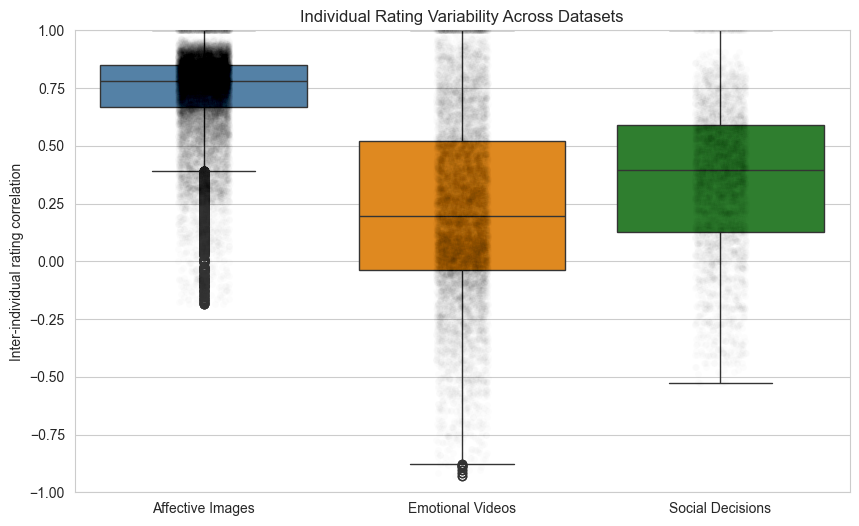

In [16]:
sns.set_style("whitegrid")

order = ['Affective Images', 'Emotional Videos', 'Social Decisions']
palette = ['steelblue', 'darkorange', 'forestgreen'] #spent some time figuring out the closest colors

plt.figure(figsize=(10, 6))
sns.boxplot(x='Context', y='Correlation', data=pairwise_results, 
            order=order, palette=palette)
sns.stripplot(x='Context', y='Correlation', data=pairwise_results, 
              order=order, color='black', alpha=.01, jitter=True) #took me a bit of searching to find out that strip plots were a thing


plt.title('Individual Rating Variability Across Datasets')
plt.ylabel('Inter-individual rating correlation')
plt.xlabel('')
plt.ylim(-1, 1)
plt.show()

If we're ever to run an experiment that relies on an individual being in a specific mental state (currently being sad, happy, etc.), it'll be important that we're able to consistently put them into that mental state. Tracking inter-individual variability allows for us have a metric for which type of stimuli is best at illiciting particular mental states-- for example, the fact that affective images have a significantly higher inter-individual rating correlation when compared to emotional videos implies that pictures (or at least, the ones in this dataset) would be better than videos (or, again, the ones in this dataset) when trying to put research participants into a particular mental state. On the other hand, if our goal is to study individual differences, then we could benefit from using a type of data that elicits individual differences. 